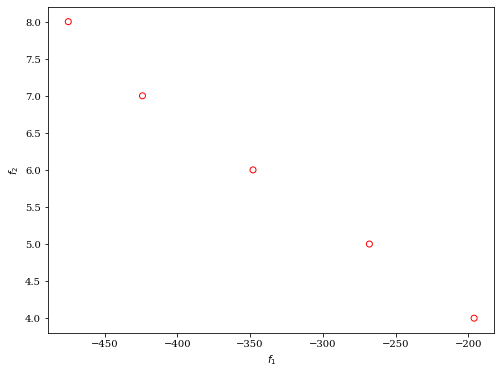

In [5]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.factory import get_problem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.problems.single.knapsack import create_random_knapsack_problem

from pymoo.core.problem import Problem
from pymoo.factory import get_algorithm, get_crossover, get_mutation, get_sampling
problem = create_random_knapsack_problem(25, variant="multi", )

class AcquisistionProblem(Problem):
    def __init__(self, n_var, n_obj, xl, xu, n_vertices, acquisition_func, surrogate_models, reference_list, inference_samples_list, partition_samples_list, isKnapsack=False):
        if isKnapsack:
            n_constr = 1
        else:
            n_constr = 0
        super().__init__(n_var, n_obj, n_constr, xl, xu, stype_var=int)
        self.isKnapsack = isKnapsack
        if self.isKnapsack:
            self.n_obj = n_obj - 1
        self.n_vertices = n_vertices
        self.acquisition_func = acquisition_func
        self.surrogate_models = surrogate_models
        self.reference_list = reference_list
        self.inference_samples_list = inference_samples_list
        self.partition_samples_list = partition_samples_list
        
    def _evaluate(self, x, out, *args, **kwargs):
        out["F"] = []
        
        results = []
        for idx, surr_model in enumerate(self.surrogate_models):
            acq_value = acquisition_expectation(torch.tensor(x), self.inference_samples_list[idx], \
                                        self.partition_samples_list[idx], self.n_vertices, \
                                                self.acquisition_func, self.reference_list[idx])
            results.append(acq_value)
        if not self.isKnapsack:
            out["F"] = np.stack(results, axis=1).reshape(-1, self.n_obj)
        else:
            out["F"] = np.stack(results[:-1], axis=1).reshape(-1, self.n_obj)
            out["G"] = results[-1].reshape(-1, )
            

algorithm = NSGA2(pop_size=20,sampling=get_sampling("int_random"),
                       crossover=get_crossover("int_sbx", prob=1.0, eta=3.0),
                       mutation=get_mutation("int_pm", eta=3.0),
                       eliminate_duplicates=True)

res_50 = minimize(problem,
               algorithm,
               ('n_gen', 10),
               seed=1,
               verbose=False)
import pickle 

with open('result_cmmo.pkl', 'rb') as f:
    data = pickle.load(f)

res = data['res']
# res_100 = minimize(problem,
#                algorithm,
#                ('n_gen', 20),
#                seed=1,
#                verbose=False)
# res_400 = minimize(problem,
#                algorithm,
#                ('n_gen', 30),
#                seed=1,
#                verbose=False)
plot = Scatter()
# plot.add(problem.pareto_front(), plot_type="line", color="black", alpha=0.7)
plot.add(res_50.F, facecolor="none", edgecolor="red")
plot.add(res.F, facecolor="none", edgecolor="blue")
plot.show()

In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '1' # speed up
import numpy as np
from MMO.problems.common import build_problem
from MMO.mobo.algorithms import get_algorithm
from MMO.visualization.data_export import DataExport
from MMO.arguments import get_args
from MMO.utils import save_args, setup_logger
import networkx as nx
import random, pickle, string
import time
import os, sys
from random import randint, shuffle, sample

sys.setrecursionlimit(2000000)
MAX_COUNT_INDEX = 3001946 # 3001946 3001946
from pymoo.optimize import minimize
from pymoo.algorithms.moo.nsga2 import NSGA2

import matplotlib.pyplot as pl

def main():
    args, framework_args = get_args()
    
    # set seed
    np.random.seed(args.seed)
    
    
    problem, pareto_front, X_init, Y_init = build_problem(args.problem, args.n_var, args.n_obj, args.n_init_sample, args.n_process)
    print(problem)
    args.n_var, args.n_obj = problem.n_var, problem.n_obj
    print("Start the optimizer")
    # initialize optimizer
    optimizer = get_algorithm(args.algo)(problem, args.n_iter, args.ref_point, framework_args)

    # save arguments & setup logger
    save_args(args, framework_args)
    logger = setup_logger(args)
    print(problem, optimizer, sep='\n')
    
    # initialize data exporter
    exporter = DataExport(optimizer, X_init, Y_init, args)

    # optimization
    solution = optimizer.solve(X_init, Y_init)

    # export true Pareto front to csv
#     if true_pfront is not None:
#         exporter.write_truefront_csv(true_pfront)

    for _ in range(args.n_iter):
        # get new design samples and corresponding performance
        X_next, Y_next, _ = next(solution)
        
        # update & export current status to csv
        exporter.update(X_next, Y_next)
        exporter.write_csvs()

    # close logger
    if logger is not None:
        logger.close()

main()


# name: MultiObjectiveKnapsack
# n_var: 50
# n_obj: 2
# n_constr: 1

Start the optimizer
# name: MultiObjectiveKnapsack
# n_var: 50
# n_obj: 2
# n_constr: 1

========== Framework Description ==========
# algorithm: USEMO_EI
# surrogate: GaussianProcess
# acquisition: EI
# solver: NSGA2Solver
# selection: Uncertainty

========== Iteration 0 ==========
Surrogate model fitted: 2.33s
Surrogate problem solved: 0.25s
Next sample batch selected: 0.00s


/mnt/c/Users/La Loc/Desktop/network_optimization_framework/MMO/mobo/mobo.py:67: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Y = np.array(Y).reshape(-1, 1)


ValueError: could not broadcast input array from shape (10,2) into shape (10,)